In [1]:
import tensorflow as tf
import numpy as np
import os
import scipy
import scipy.ndimage
import scipy.misc
import matplotlib.pyplot as plt

from scipy.ndimage.interpolation import shift, rotate, zoom

In [52]:
class AllData(object):
    def __init__(self, location):
        '''
        Reads in the training and testing labels provided for the multi-task
        facial recognition system. 

        Inputs:
          location - String containing the location of the text file with the
            training/testing labels and data locations.
        '''
        self.location = location
        self.train_data = []
        self.test_data = []
        self.num_landmarks = 5
        filenames = ('training.txt', 'testing.txt')
        for name in filenames:
            with open(os.path.join(location, name), 'r') as f:
                for line in f.readlines():
                    if len(line) > 1:
                        if 'train' in name:
                            self.train_data.append(self._parseLine(line))
                        else:
                            self.test_data.append(self._parseLine(line))
                    
        train_indices = [i for i in range(len(self.train_data))]
        test_indices = [i for i in range(len(self.test_data))]
        #print(train_indices)
        np.random.shuffle(train_indices)
        #print(train_indices)
        self._train_indices = train_indices
        self._test_indices = test_indices
        print('train_data:', self.train_data[0])
            
    def _parseLine(self, line):
        '''
        Parses a line read from the training and testing labels. This text
        file doesn't directly contain the training data, but it includes
        relative references to the locations of the images and the
        corresponding labels for each image.

        A line from the text file contains the following information:
        [image_location, l_eye_x, r_eye_x, nose_x, l_mouth_x, r_mouth_x,
            l_eye_y, r_eye_y, nose_y, l_mouth_y, r_mouth_y,
            gender {1, 2}, smile {1, 2}, glasses {1, 2}, head_pose {1, 2, 3, 4, 5}]
        '''
        if line[0] == ' ':
            line = line[1:len(line)]
            
        items = line.split(' ')
        
        if len(items) != 15:
            print('Received unexpected number of items')
            print(line)
        
        image = items[0]
        coords = items[1:11]
        
        pairs = []
        for i in range(5):
            pairs.append((float(coords[i]), float(coords[i+5])))
            
        categories = []
        num_categories = [2, 2, 2, 5]
        
        for i, index in enumerate(items[11:15]):
            c = np.zeros(num_categories[i])
            c[int(index) - 1] = 1.
            categories.append(c)
            
        return image, tuple(pairs), tuple(categories)
    
    def _get_batch(self, batch_size, dataset, image_resize):
        
        if 'train' in dataset.lower():
            data = self.train_data
            batch_indices = self._train_indices[0:batch_size]
        elif 'test' in dataset.lower():
            data = self.test_data
            batch_indices = self._test_indices.copy()
            np.random.shuffle(batch_indices)
            batch_indices = batch_indices[0:batch_size]
            print(batch_indices)
        else:
            return
        
        num_landmarks = self.num_landmarks
        
        image_names = [data[i][0] for i in batch_indices]
        images = tuple([scipy.ndimage.imread(os.path.join(self.location, n), flatten=True) for n in image_names])
        landmarks = [data[i][1] for i in batch_indices]
        
        for i in range(batch_size):
            self.plot_image_and_landmarks(images[i], landmarks[i])

        # Rotate, zoom, translate
        if 'train' in dataset.lower() and np.random.rand() > 0.5:
            #images, landmarks = _zoom(images, landmarks)
            images, landmarks = _translate(images, landmarks)
            images, landmarks = _rotate(images, landmarks)
            #pass

        images_scaled = np.zeros((batch_size, image_resize[0], image_resize[1], 1))
        for i, im in enumerate(images):
            #images_scaled = [scipy.misc.imresize(i, image_resize) for i in images]
            images_scaled[i,:,:,0] = scipy.misc.imresize(im, image_resize)

        # Add static
 
        # Grab all of the landmarks, then scale them down to match the size
        # of the down-scaled image.
        _landmarks_scaled = []
        for n in range(len(landmarks)):
            _landmarks_scaled.append(list(map(lambda x: _scale_landmark(x, images[n].shape, image_resize), landmarks[n])))

        # Turns the tuple of tuples of landmarks into one giant matrix
        #   [batch_size, num_landmarks*2]
        #   The factor of two is inserted because there are two coordinates
        #   that will need to be regressed.
        landmarks_scaled = None
        for n in range(len(landmarks)):
            landmark_row = []
            for m in range(num_landmarks):
                landmark_row.append(np.expand_dims(_landmarks_scaled[n][m], axis=0))
                np.concatenate(_landmarks_scaled[n], axis=0)
            landmark_row = np.expand_dims(np.concatenate(landmark_row, axis=0), axis=0)
            if landmarks_scaled is None:
                landmarks_scaled = landmark_row
            else:
                landmarks_scaled = np.concatenate([landmarks_scaled, landmark_row], axis=0)
        landmarks_scaled = np.reshape(landmarks_scaled, [batch_size, num_landmarks*2])
        
        gender = np.concatenate([np.expand_dims(data[i][2][0], axis=0) for i in batch_indices], axis=0)
        smile = np.concatenate([np.expand_dims(data[i][2][1], axis=0) for i in batch_indices])
        glasses = np.concatenate([np.expand_dims(data[i][2][2], axis=0) for i in batch_indices])
        pose = np.concatenate([np.expand_dims(data[i][2][3], axis=0) for i in batch_indices])
        
        # If there aren't enough training indices to fill another batch of
        # the size just requested, then the training indices are reset
        # and shuffled.
        if 'train' in dataset.lower():
            self._train_indices = self._train_indices[batch_size:]
            if len(self._train_indices) <= batch_size:
                self._train_indices = [i for i in range(len(self.train_data))]
                np.random.shuffle(self._train_indices)

        return images_scaled, landmarks_scaled, gender, smile, glasses, pose
    
    def get_train_batch(self, batch_size, image_resize=(40, 40)):
        return self._get_batch(batch_size, 'train', image_resize)
    
    def get_test_batch(self, batch_size, image_resize=(40, 40)):
        return self._get_batch(batch_size, 'test', image_resize)
        
    def plot_image_and_landmarks(self, image, landmarks):
        plt.figure()
        plt.imshow(image, cmap='gray')
        for l in landmarks:
            plt.scatter(l[0], l[1])
        plt.show()

def _add_static(images, min_, max_):
    '''
    Applies random static to a rank 3 tensor consisting of individual images
    that have already undergone all possible geometric transformations.
    This should come along after geometric distortions.
    The maximum value of 'images' should not exceed 1.
    '''
    a, b, c, d = images.shape
    static = np.random.rand(a, b, c, d)/100.
    images += static
    images /= np.amax(images)
    return images

def _translate(images, landmarks, min_=-50, max_=50):
    '''
    Takes a tuple or list of images and landmarks and applies a random
    translation along the x and y axes of each image in the list.

    Inputs:
      images - A tuple of numpy arrays. Each element of the tuple is an image
        represented by 2D numpy array.
      landmarks - A tuple of tuples of facial landmarks. The outer tuple
        contains the set of landmarks associated with an image of the same
        index.
      min_ - Smallest amount (in pixels) of translation that can be applied to
        an image. Default = -50 pixels
      max_ - Largest amount (in pixels) of translation that can be applied to an
        image. Default = 50 pixels

    Outputs:
      A tuple consisting of translated images and landmarks.

    '''
    m, b = _scale(0., 1., min_, max_)
    images = list(images)
    landmarks = list(landmarks)
    
    for i in range(len(images)):
        #t = np.ndarray.tolist((np.random.rand(2)*m + b).astype(int))
        t = (np.random.rand(2)*m + b).astype(int)
        
        images[i] = shift(images[i], np.ndarray.tolist(t))
        landmarks[i] = list(landmarks[i])

        for j in range(len(landmarks[i])):
            l = landmarks[i][j] + t.astype(float)[::-1]
            landmarks[i][j] = tuple(np.ndarray.tolist(l))
        landmarks[i] = tuple(landmarks[i])

    return tuple(images), tuple(landmarks)

def _zoom(images, landmarks, min_=0.5, max_=1.3):
    '''
    Takes a tuple or list of images and landmarks and zooms them by a
    random amount between min_ and max_.

    Inputs:
      images - A tuple of numpy arrays. Each element of the tuple is an image
        represented by 2D numpy array.
      landmarks - A tuple of tuples of facial landmarks. The outer tuple
        contains the set of landmarks associated with an image of the same
        index.
      min_ - Smallest zoom (as a fraction) of that can be applied to an image.
        Default = 1.0
      max_ - Largest zoom (as a fraction) of that can be applied to an image.
        Default = 1.3

    Outputs:
      A tuple consisting of zoomed images and landmarks.
    '''
    images = list(images)
    landmarks = list(landmarks)
    m, b = _scale(0., 1., min_, max_)
    for i in range(len(images)):
        z = np.random.rand()*m + b
        print(z)
        w, h = images[i].shape
        images[i] = zoom(images[i], z)[:w, :h]
        landmarks[i] = list(landmarks[i])
        for j in range(len(landmarks[i])):
            
            l = np.asarray(landmarks[i][j])
            landmarks[i][j] = tuple(np.ndarray.tolist(l*z))
        landmarks[i] = tuple(landmarks[i])

    return tuple(images), tuple(landmarks)

def _rotate(images, landmarks, min_=-30, max_=30):
    '''
    Takes a tuple or list of images and landmarks and rotates them by a
    random amount between min_ and max_. 

    Inputs:
      images - A tuple of numpy arrays. Each element of the tuple is an image
        represented by 2D numpy array.
      landmarks - A tuple of tuples of facial landmarks. The outer tuple
        contains the set of landmarks associated with an image of the same
        index.
      min_ - Smallest angle (in degrees) of rotation that can be applied to
        an image. Default = -30 degrees
      max_ - Largest angle (in degrees) of rotation that can be applied to an
        image. Default = 30 degrees

    Outputs:
      A tuple consisting of rotated images and landmarks.
    '''
    images = list(images)
    landmarks = list(landmarks)
    m, b = _scale(0., 1., min_, max_)
    for i in range(len(images)):
        # Generate a random angle for each image/landmark in the set.
        angle = np.random.rand()*m + b
        radian = angle*np.pi/180.
        si = np.sin(radian)
        co = np.cos(radian)

        # Build a 2D rotation matrix out of the randomly generated angle.
        R = np.matrix([[co, si],[-si, co]])
        # The image rotation is performed about the geometric center of the
        # image, so the landmarks must be rotated about the same point.
        c = np.asarray(images[i].shape[:2])/2.
        landmarks[i] = list(landmarks[i])
        # Apply rotation to the current image.
        images[i] = rotate(images[i], angle, reshape=False)
        # Apply rotation to each landmark for the current image.
        for j in range(len(landmarks[i])):
            
            l = np.expand_dims(np.asarray(landmarks[i][j]) - c, axis=1)
            #landmarks[i][j] = np.ndarray.tolist(np.squeeze(np.dot(R, l)) + c)
            landmarks[i][j] = ((np.dot(R, l) + c)[0,1], (np.dot(R, l) + c)[1,1])
        landmarks[i] = tuple(landmarks[i])

    return tuple(images), tuple(landmarks)

def _scale(x0, x1, y0, y1):
    '''
    Applies a simple linear scaling between two ranges of values.
    '''
    m = (y0 - y1)/(x0 - x1)
    b = y1 - m*x1
    return m, b

def _scale_landmark(l, s, r):
    '''
    Takes a landmark and scales it down according to the ratio
    (w_1/w_0, h_1/h_0)
    where the image's initial size is (w_0, h_0), and its resized dimensions
    are (w_1, h_1).
    
    Input:
      l - a tuple or list of coordinates indicating a facial landmark
      s - tuple or list of dimensions of the image before scaling
      r - tuple or list of dimensions of the image after scaling

    Output:
      numpy array with two elements representing the scaled down coordinates
      of the facial landmark.

    '''
    return np.asarray([l[0]*float(r[1])/float(s[1]), l[1]*float(r[0])/float(s[0])])

train_data: ('lfw_5590\\Aaron_Eckhart_0001.jpg', ((107.25, 108.75), (147.75, 113.25), (126.25, 143.75), (106.25, 158.75), (140.75, 162.75)), (array([ 1.,  0.]), array([ 0.,  1.]), array([ 0.,  1.]), array([ 0.,  0.,  1.,  0.,  0.])))


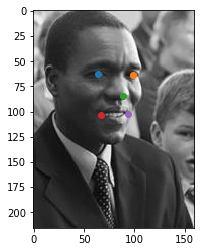

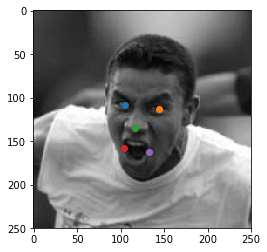

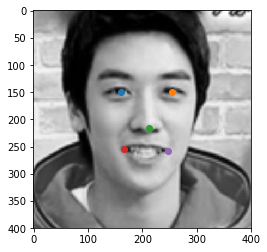

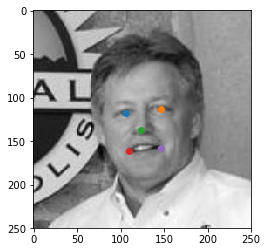

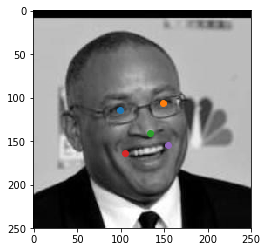

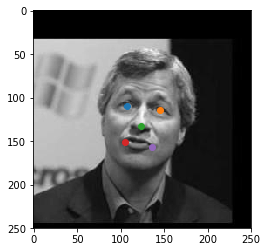

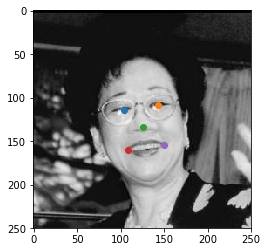

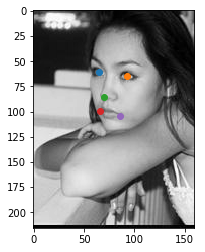

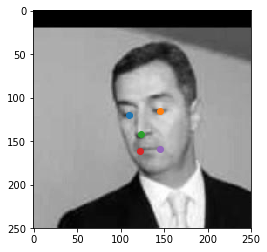

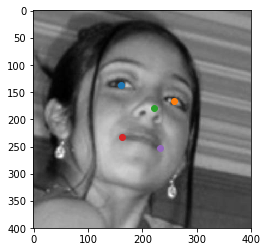

In [55]:
d = AllData('mtfl')
things = d.get_train_batch(10)

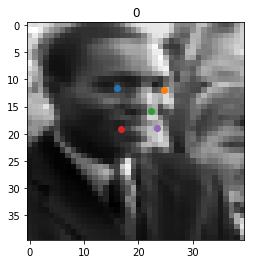

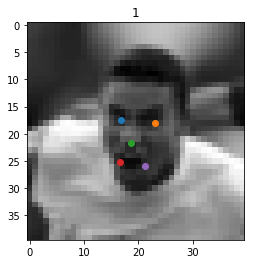

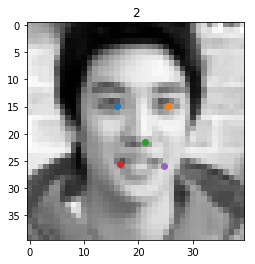

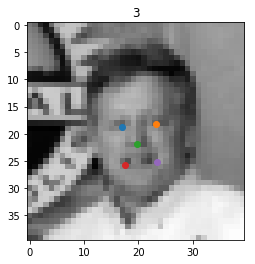

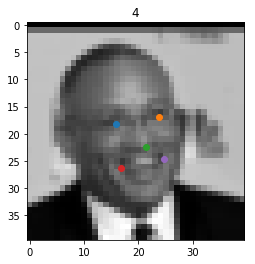

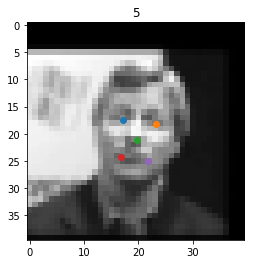

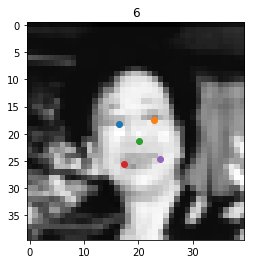

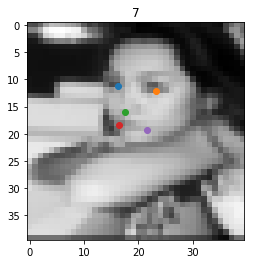

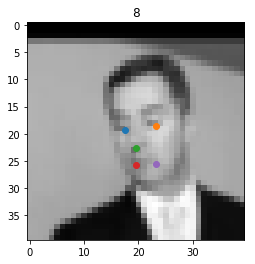

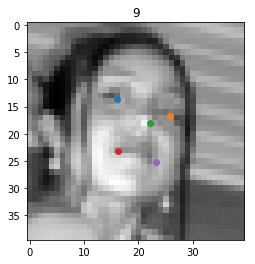

16.52 18.2


In [56]:
for i in range(len(things[0])):
    plt.figure()
    plt.imshow(things[0][i,:,:,0], cmap='gray')
    plt.scatter(things[1][i][0], things[1][i][1])
    plt.scatter(things[1][i][2], things[1][i][3])
    plt.scatter(things[1][i][4], things[1][i][5])
    plt.scatter(things[1][i][6], things[1][i][7])
    plt.scatter(things[1][i][8], things[1][i][9])
    plt.title(i)
plt.show()
print(things[1][6][0], things[1][6][1])

In [5]:
len(d._train_indices)

10000

In [6]:
print(things[1].shape)
#print(things[2].shape)

(100, 10)


In [7]:
print(things[2], '\n\n', things[3], '\n\n', things[4], '\n\n', things[5])

[[ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]